## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from tqdm.autonotebook import tqdm

import amp_research.price_movement_analysis as pma
import helpers.dbg as dbg
import helpers.env as env
import helpers.printing as pri
import helpers.s3 as hs3
import vendors.cme.read as cmer
import vendors.kibot.utils as kut

/Users/saggese/.conda/envs/p1_develop/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
print(env.get_system_signature())

pri.config_notebook()

dbg.init_logger(verb=logging.INFO)

_LOG = logging.getLogger(__name__)

# Packages
         python: 3.7.3
         joblib: 0.14.0
          numpy: 1.17.2
         pandas: 0.25.1
        pyarrow: 0.15.0
          scipy: 1.3.1
        seaborn: 0.9.0
        sklearn: 0.21.3
    statsmodels: 0.10.1
# Last commits:
  *   7806350 saggese  Merge branch 'master' into PartTask218_PRICE_Large_price_movement_analysis ( 2 minutes ago) Wed Oct 16 09:28:41 2019  (HEAD -> PartTask218_PRICE_Large_price_movement_analysis, origin/PartTask218_PRICE_Large_price_movement_analysis)
  |\  
  | * c1b93f8 saggese  Wire up incremental mode and add documentation                    (  18 hours ago) Tue Oct 15 15:54:35 2019  (origin/master, origin/HEAD, master)
  | * ff51d7b saggese  Lint                                                              (  18 hours ago) Tue Oct 15 15:31:53 2019           


# Load CME metadata

In [4]:
product_list = cmer.read_product_specs()

Reading s3://default00-bucket/cme/product_slate_export_with_contract_specs_20190905.csv


In [5]:
product_list.head()

,Clearing,Globex,Floor,Clearport,Product Name,Product Group,Sub Group,Category,Sub Category,Cleared As,Exchange,Volume,Open Interest,product_link,Contract Unit,Price Quotation,Trading Hours,Minimum Price Fluctuation,Product Code,Listed Contracts,Settlement Method,Termination Of Trading,Settlement Procedures,Position Limits,Exchange Rulebook,Block Minimum,Price Limit Or Circuit,All Or None Minimum,Vendor Codes,Settlement Procedures Link,Position Limits Link,Exchange Rulebook Link,Block Minimum Link,Price Limit Or Circuit Link,All Or None Minimum Link,Vendor Codes Link,Delivery Procedure,Last Delivery Date,Grade And Quality,Trade At Marker Or Trade At Settlement Rules,Delivery Period,Minimum Price Fluctuation_0,Grade And Quality Link,Floating Price,Days Or Hours,Trading Hours_0,Delivery Period Link,Delivery Procedure Link,Trade At Marker Or Trade At Settlement Rules Link,Minimum Price Fluctuation Link,Listed Contracts Link,Termination Of Trading_0,Termination Of Trading Link,Reportable Positions,Termination Of Trading_1,CME Globex:,Reportable Positions Link
0,ED,GE,NaN,ED,Eurodollar Futures,Interest Rate,Stirs,NaN,NaN,Futures,CME,3104281,13213901,http://www.cmegroup.com/trading/interest-rates...,"$2,500 x Contract IMM Index",Contract IMM Index = 100 minus R R = three-mon...,SUN - FRI: 5:00 p.m. - 4:00 p.m. CT,Nearest expiring contract month: One quarter o...,CME Globex: GECME ClearPort: EDClearing: ED,"Nearest 40 months (i.e., 10 years) in the Marc...",Financially Settled,Second London bank business day before 3rd Wed...,Eurodollar Future Settlement Procedures,CME Position Limits,CME 452,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/confluence/display/EPI...,http://www.cmegroup.com/rulebook/files/positio...,http://www.cmegroup.com/rulebook/CME/V/450/452...,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/rulebook/files/special...,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/tools-information/vend...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,ZF,NaN,25,5-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,CBOT,1166719,4162661,http://www.cmegroup.com/trading/interest-rates...,"Face value at maturity of $100,000",Points and fractions of points with par on the...,SUN - FRI: 5:00 p.m. - 4:00 p.m.,One-quarter of one thirty-second (1/32) of one...,CME Globex: ZFCME ClearPort: 25Clearing: 25,The first three consecutive contracts in the M...,Deliverable,Last business day of the calendar month. Tradi...,Treasury Settlement Procedures,CBOT Position Limits,CBOT 20,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/confluence/display/EPI...,http://www.cmegroup.com/rulebook/files/positio...,https://www.cmegroup.com/rulebook/CBOT/II/20.pdf,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/rulebook/files/special...,/clearing/trading-practices/all-or-none.html,http://www.cmegroup.com/tools-information/vend...,Federal Reserve book-entry wire-transfer system.,Third business day following the last trading ...,U.S. Treasury notes with an original term to m...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,ZN,NaN,21,10-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,CBOT,2181982,3656744,http://www.cmegroup.com/trading/interest-rates...,"Face value at maturity of $100,000",Points and fractions of points with par on the...,Sunday - Friday 6:00 p.m. - 5:00 p.m. (5:00 p....,Outrights: One-half of one thirty-second (1/32...,CME Globex: ZNCME ClearPort: 21Clearing: 21,"Quarterly contracts (Mar, Jun, Sep, Dec) liste...",Deliverable,Trading terminates on the seventh business day...,Treasury Settlement Procedures,CBOT Position Limits,CBOT Chapter 19,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/

In [6]:
product_list["Product Group"].value_counts()

Energy           892
Equities         100
Agriculture       57
FX                55
Metals            44
Interest Rate     30
Name: Product Group, dtype: int64

In [7]:
product_list.set_index("Product Group", inplace=True)

In [8]:
commodity_groups = ["Energy", "Agriculture", "Metals"]

In [9]:
commodity_symbols = {
    group: product_list.loc[group]["Globex"].values for group in commodity_groups
}

In [10]:
commodity_symbols

{'Energy': array(['CL', 'NG', 'NN', 'N9L', 'D2L', 'HO', 'RB', 'H2L', 'HH', 'BZ',
        'V3L', 'BK', 'CSX', 'HTT', 'B0', 'NPG', 'WTT', 'B6L', 'E4L', 'HP',
        'AL1', 'AFF', 'EJL', 'LT', 'AD0', 'A1R', 'R7L', 'D4L', 'AW6', 'CU',
        'ADB', 'AC0', 'L3L', 'A4P', 'ME', 'CY', 'WOL', 'A8K', 'T7K', 'ZGL',
        'MTF', 'LPS', 'T3L', 'AE5', 'AYV', 'MFB', 'AU6', 'RBB', 'AWJ',
        'POL', 'A7Q', 'IDL', 'PWL', 'AZ9', 'RVR', 'ZJL', 'TL', 'A46', 'GZ',
        'RLX', 'K4L', 'FTL', 'HOB', 'GCU', 'CRB', 'WCW', 'AOL', 'JDL',
        'EN', 'AA6', 'PD', 'AGA', 'FO', 'N1B', 'NOI', 'MPX', 'NHN', 'NL',
        'JKM', 'MTS', 'AB3', 'NR', 'AH3', 'AP8', 'A7E', 'PGN', 'AFH',
        'AZ1', 'A8I', 'MNC', 'UV', 'SE', 'MAF', 'B7H', 'J4L', 'AYX', 'QM',
        'D3L', 'IN', 'MEO', 'QG', 'EXR', 'PM', 'TTF', 'MFF', 'PGG', 'D7L',
        'BOO', 'MXB', 'EVC', 'A5C', 'AA8', 'EWG', 'HB', 'A8O', 'RKA',
        'ARE', 'GCI', 'A1M', 'AL6', 'A1L', 'A0D', 'MBR', 'APS', 'N3L',
        'JET', 'VR', 'A9N', 'PH', 'PEL'

# Daily price movements

## Load kibot commodity daily prices

In [11]:
daily_metadata = kut.read_metadata2()
daily_metadata.head(3)

,Symbol,Link,Description
All_Futures_Contracts_daily.csv,,,
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019


In [12]:
len(daily_metadata["Symbol"])

14962

In [13]:
daily_metadata["Symbol"].nunique()

14962

In [14]:
len(commodity_symbols["Energy"])

892

In [15]:
energy_symbols_kibot = np.intersect1d(
    daily_metadata["Symbol"].values, commodity_symbols["Energy"]
)
energy_symbols_kibot

array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
       'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
       'TM', 'TW'], dtype=object)

In [16]:
len(energy_symbols_kibot)

23

In [17]:
commodity_symbols_kibot = {
    group: np.intersect1d(
        daily_metadata["Symbol"].values, commodity_symbols[group]
    )
    for group in commodity_symbols.keys()
}

In [18]:
commodity_symbols_kibot

{'Energy': array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
        'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
        'TM', 'TW'], dtype=object),
 'Agriculture': array(['GF', 'HE', 'LE', 'TT', 'ZCT', 'ZLT', 'ZMT', 'ZWT'], dtype=object),
 'Metals': array(['GC', 'GCK', 'HG', 'HGT', 'MGC', 'PA', 'PL', 'QC', 'QI', 'QO',
        'SI', 'SIL', 'UX'], dtype=object)}

In [19]:
{
    group: len(commodity_symbols_kibot[group])
    for group in commodity_symbols_kibot.keys()
}

{'Energy': 23, 'Agriculture': 8, 'Metals': 13}

In [20]:
comm_list = []
for comm_group in commodity_symbols_kibot.values():
    comm_list.extend(list(comm_group))
comm_list[:5]

['ALM', 'BB', 'BZ', 'CCM', 'CL']

In [34]:
len(comm_list)

44

In [35]:
s3_path = hs3.get_path()
kibot_path = os.path.join(
    s3_path, "kibot/All_Futures_Continuous_Contracts_daily/%s.csv.gz"
)

daily_price_dict_df = kut.read_multiple_symbol_data(
    comm_list, kibot_path, nrows=None
)

daily_price_dict_df["CL"].tail(2)

,open,high,low,close,vol
date,,,,,
2019-07-18,56.72,57.45,54.85,55.42,764491
2019-07-19,55.84,56.49,55.12,55.76,710948


## Largest movements for a specific symbol

In [36]:
symbol = "CL"

In [23]:
top_daily_movements_cl = pma.get_top_movements_for_symbol(
    daily_price_dict_df, symbol, "daily"
)
top_daily_movements_cl.head()

date
2014-12-01    3.655719
2001-11-16    3.645029
2001-09-25    3.515338
2002-03-18    3.365737
2011-05-06    3.333398
Name: ret_0, dtype: float64

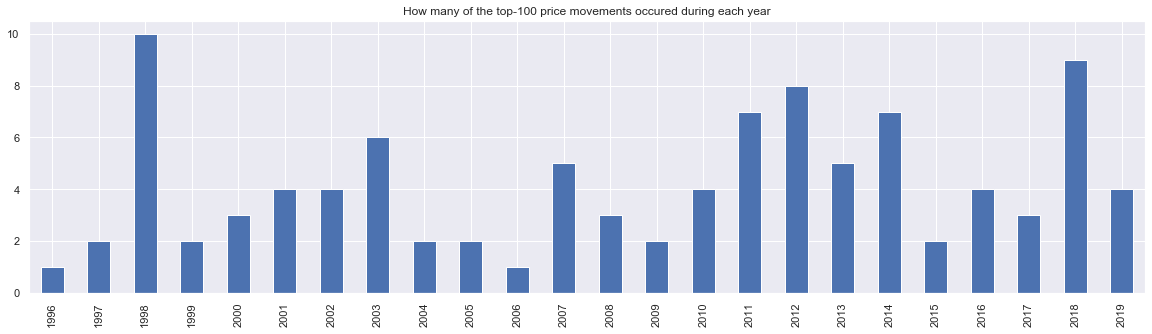

In [24]:
top_daily_movements_cl.index.year.value_counts(sort=False).plot(kind="bar")
plt.title("How many of the top-100 price movements occured during each year")
plt.show()

## Largest movement for energy group

In [25]:
group = "Energy"

In [26]:
commodity_symbols_kibot[group]

array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
       'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
       'TM', 'TW'], dtype=object)

In [27]:
pma.get_top_movements_by_group(
    daily_price_dict_df, commodity_symbols_kibot, group, "daily"
)

/Users/saggese/.conda/envs/p1_develop/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/saggese/.conda/envs/p1_develop/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


date
2016-03-01         inf
2016-02-19         inf
2016-03-11         inf
2016-03-09         inf
2016-03-17         inf
2016-03-04         inf
2016-03-03         inf
2016-03-02         inf
2016-03-16         inf
2016-02-25         inf
2016-02-24         inf
2008-02-18         inf
2016-03-15         inf
2016-02-18         inf
2008-04-07         inf
2008-02-19         inf
2016-02-17         inf
2017-03-20         inf
2017-03-17         inf
2008-04-04         inf
2016-02-16         inf
1999-03-11    2.535575
1996-01-08    2.498073
1995-12-11    2.272908
2004-11-25    2.224133
1998-03-19    2.197773
1998-01-27    2.154381
1996-01-12    2.107268
2011-08-05    2.095441
1997-09-26    2.040933
2002-05-16    2.033812
1997-08-05    1.979685
1996-05-24    1.971286
1997-09-29    1.958196
2010-11-28    1.956024
1995-12-05    1.951210
1999-05-07    1.949525
1998-03-17    1.892760
1997-10-07    1.886392
1995-11-03    1.871106
2008-09-30    1.854969
1998-09-11    1.845369
1995-12-19    1.843897
1998-1

## Largest movements for each group

In [28]:
top_100_daily_movements_by_group = {
    group: pma.get_top_movements_by_group(
        daily_price_dict_df, commodity_symbols_kibot, group, "daily"
    )
    for group in tqdm(commodity_symbols_kibot.keys())
}

In [29]:
{
    group: head_prices_group.head(15)
    for group, head_prices_group in top_100_daily_movements_by_group.items()
}

{'Energy': date
 2016-03-01    inf
 2016-02-19    inf
 2016-03-11    inf
 2016-03-09    inf
 2016-03-17    inf
 2016-03-04    inf
 2016-03-03    inf
 2016-03-02    inf
 2016-03-16    inf
 2016-02-25    inf
 2016-02-24    inf
 2008-02-18    inf
 2016-03-15    inf
 2016-02-18    inf
 2008-04-07    inf
 dtype: float64, 'Agriculture': date
 2019-07-19    inf
 2018-02-08    inf
 2018-03-01    inf
 2018-02-28    inf
 2018-02-21    inf
 2018-02-20    inf
 2018-02-13    inf
 2018-02-12    inf
 2018-02-09    inf
 2017-12-01    inf
 2019-04-02    inf
 2015-06-23    inf
 2015-07-06    inf
 2015-07-07    inf
 2015-07-23    inf
 dtype: float64, 'Metals': date
 2007-12-02    3.582814
 2013-04-15    2.816036
 2013-04-16    2.735094
 2013-07-04    2.715543
 2007-02-19    2.699586
 1999-09-29    2.697176
 2001-09-14    2.629436
 2011-05-30    2.624040
 2011-02-21    2.535389
 1996-01-03    2.500343
 2004-04-14    2.388859
 2007-08-17    2.387430
 2014-12-01    2.353821
 2018-06-18    2.313707
 2013-01-

# 1-minute price movements

## Load 1-minute prices

In [30]:
minutely_metadata = kut.read_metadata1()

In [31]:
minutely_metadata.head()

,Symbol,Link,Description
All_Futures_Contracts_1min.csv,,,
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019
4,JYG18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN FEBRUARY 2018
5,JYG19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN FEBRUARY 2019


In [32]:
np.array_equal(
    minutely_metadata["Symbol"].values, minutely_metadata["Symbol"].values
)

True

In [37]:
len(comm_list)

44

In [ ]:
s3_path = hs3.get_path()
kibot_path = os.path.join(
    s3_path, "kibot/All_Futures_Continuous_Contracts_1min/%s.csv.gz"
)

minutely_price_dict_df = kut.read_multiple_symbol_data(
    comm_list, kibot_path, nrows=None
)

daily_price_dict_df["CL"].tail(2)

args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/HO.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/HO.csv.gz', None) kwargs={}
Reading file_name='s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/HO.csv.gz' nrows=None
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/IN.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/IN.csv.gz', None) kwargs={}
Reading file_name='s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/IN.csv.gz' nrows=None
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/JE.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/JE.csv.gz', None) kwargs={}
Reading file_name='s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/JE.csv.gz' nrows=None
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/

In [ ]:
minutely_price_dict_df["CL"].head()

In [ ]:
# five_min_price_dict_df = {
#     symbol: minutely_price_dict_df[symbol].resample("5Min").sum()
#     for symbol in minutely_price_dict_df.keys()
# }

## Top movements for a symbol

In [ ]:
symbol = "CL"

In [ ]:
top_100_movements_cl_1_min = pma.get_top_movements_for_symbol(
    minutely_price_dict_df, symbol, "minutely"
)

In [ ]:
top_100_movements_cl_1_min.head()

In [ ]:
# top_100_movements_cl_5_min = pma.get_top_movements_for_symbol(
#     five_min_price_dict_df, symbol
# )

In [ ]:
# top_100_movements_cl_5_min.head()

In [ ]:
top_100_movements_cl_1_min.plot(kind="bar")
plt.title(
    f"Largest price movements in a 1 min interval (in z-score space) for {symbol} symbol"
)
plt.show()

In [ ]:
print(f"Top 100 of the price movements for {symbol} occur at the following time:")
print(pd.Series(top_100_movements_cl_1_min.index).dt.time.value_counts())

## Largest movements for energy group

In [ ]:
group = "Energy"

In [ ]:
commodity_symbols_kibot[group]

In [ ]:
pma.get_top_movements_by_group(
    minutely_price_dict_df, commodity_symbols_kibot, group, "minutely"
)

## Largest movements for each group

In [ ]:
top_100_1_min_movements_by_group = {
    group: pma.get_top_movements_by_group(
        minutely_price_dict_df, commodity_symbols_kibot, group, "minutely"
    )
    for group in tqdm(commodity_symbols_kibot.keys())
}

In [ ]:
{
    group: head_prices_group.head()
    for group, head_prices_group in top_100_1_min_movements_by_group.items()
}